# Data Exploration

In [2]:
library(tidyverse)
library(scales) # scales::percent
library(cowplot) # plot_grid
library(zeallot) # %<-% 
library(GGally) # ggpairs
options(repr.plot.width=14, repr.plot.height=9)
housing_orig <- read.csv("_datasets/housing.csv") %>% as_tibble

# Add interesting attributes (note the NAs in total_bedrooms)
housing <- housing_orig %>%
    mutate(rooms_per_household = total_rooms / households) %>%
    mutate(bedrooms_per_room = total_bedrooms / total_rooms) %>%
    mutate(population_per_household = population / households) %>%
    # categorize income
    mutate(incomecat = cut(median_income, c(0, 1.5, 3, 4.5, 6, Inf)))

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.4
✔ tibble  3.0.1     ✔ dplyr   1.0.0
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor



********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



## Histogram of every (numeric) attribute

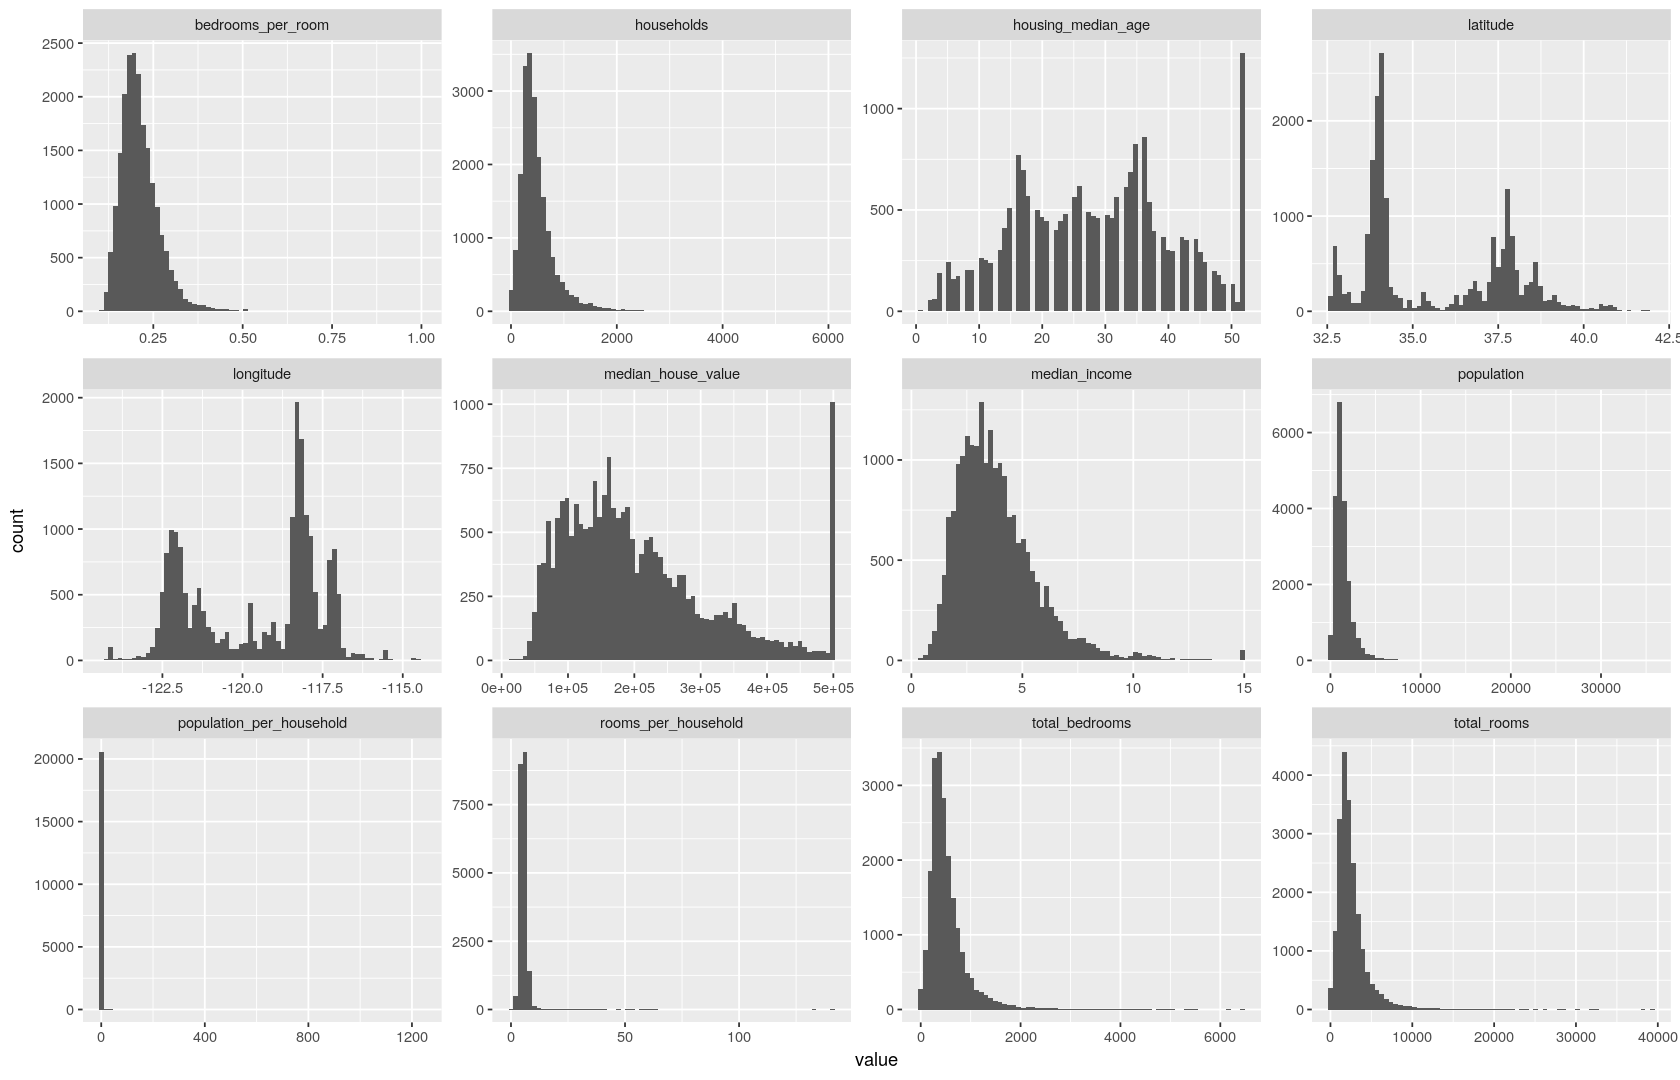

In [3]:
housing %>% 
    keep(is.numeric) %>%
    pivot_longer(longitude:population_per_household, names_to="what", values_to="value") %>%
    filter(!is.na(value)) %>%
ggplot +
    geom_histogram(aes(x=value), bins=70) +
    facet_wrap(~what, scales="free")

## Categorical Income

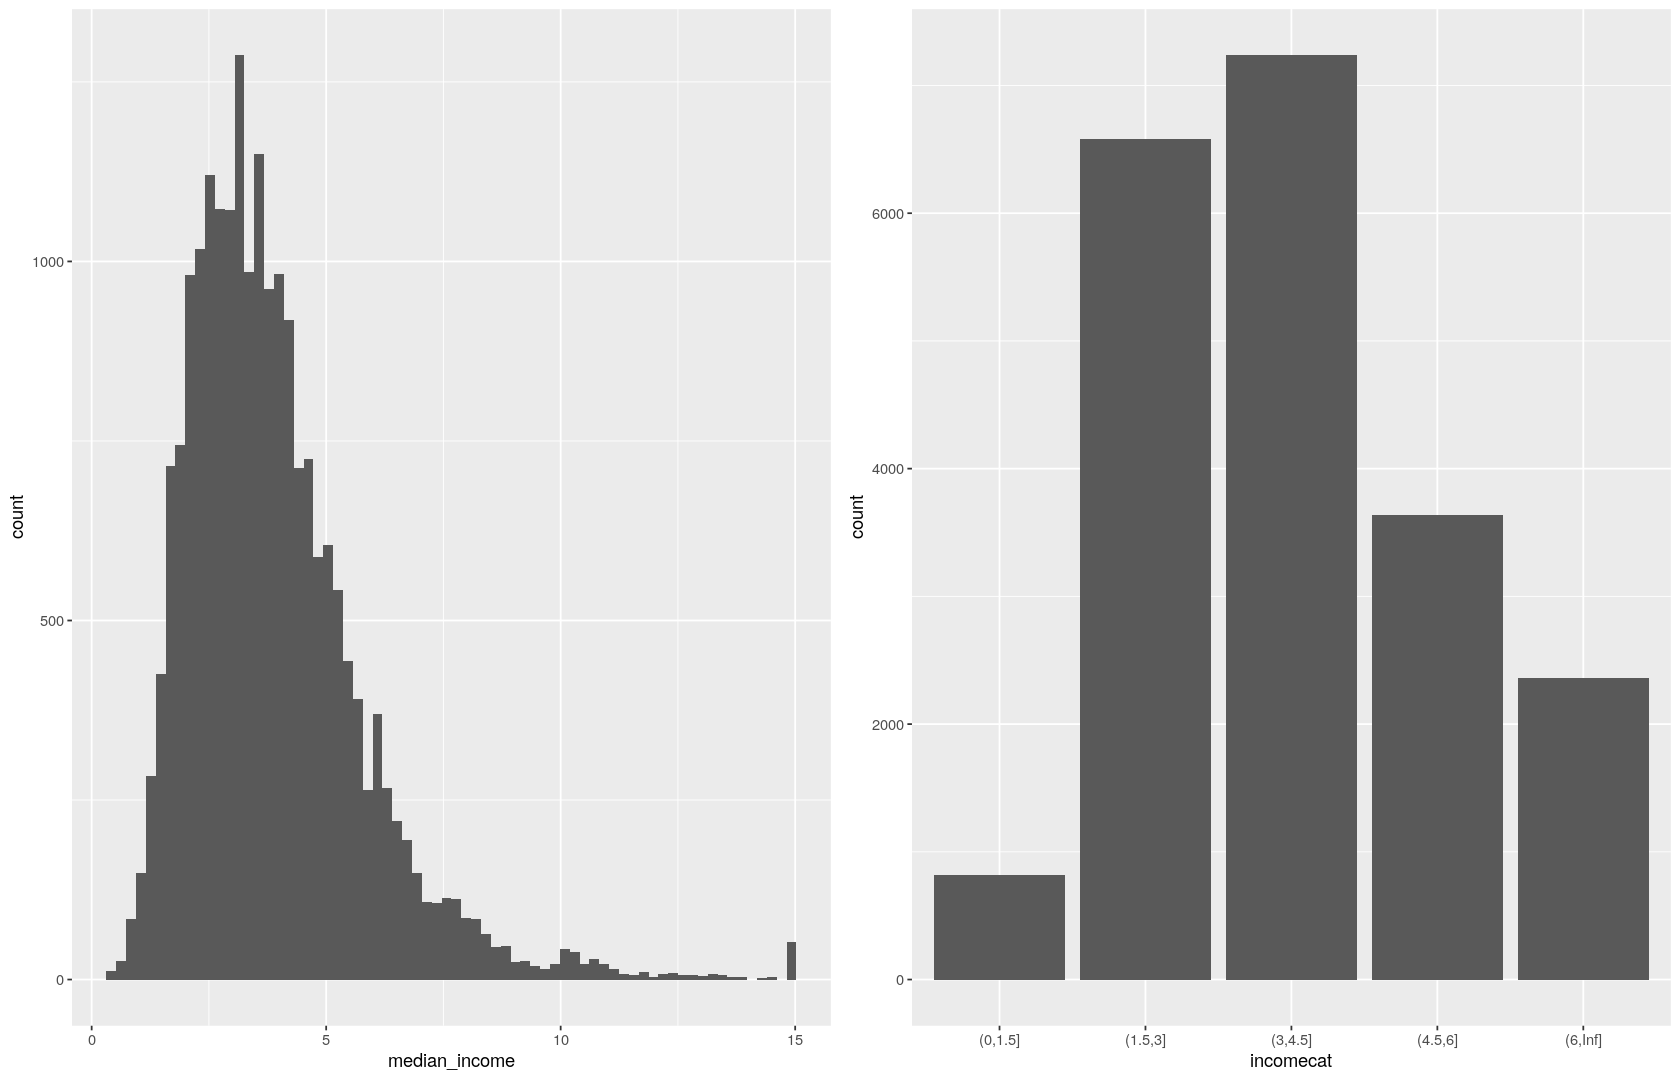

In [4]:
p1 <- ggplot(housing) + geom_histogram(aes(x=median_income), bins=70)
p2 <- ggplot(housing) + geom_bar(aes(x=incomecat))
plot_grid(p1, p2)

## Pairwise Scatter Matrix

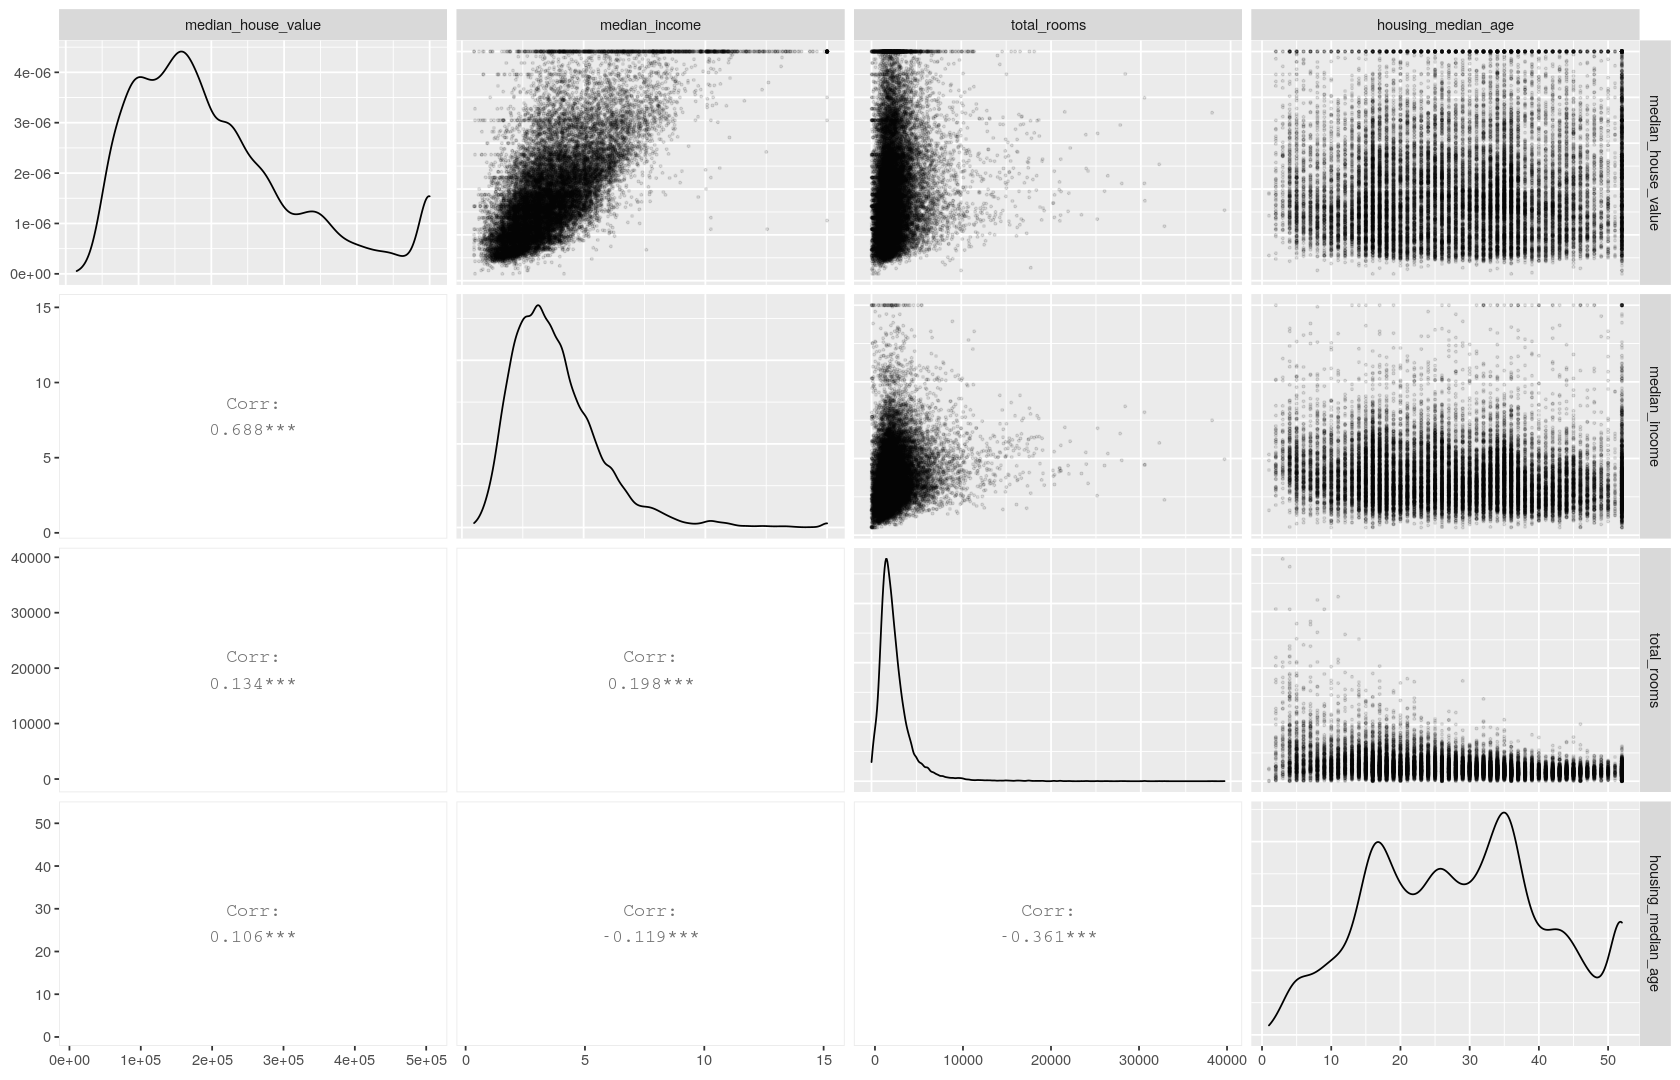

In [5]:
housing %>%
    select(c(median_house_value, median_income, total_rooms, housing_median_age)) %>%
    ggpairs(upper = list(continuous = wrap("points", alpha=0.1, size=0.5)),
            lower = list(continuous = "cor"))

# Data Preparation

## Stratified Shuffle Split (hold-out validation)

In [6]:
shuffle_split_rng <- function(data, proportion, seed=NA) {
    if (! is.na(seed)) { set.seed(seed) }
    permutated_indices <- sample(nrow(data))
    num_of_elems_in_split <- floor(nrow(data) * proportion)
    split <- data[permutated_indices,][1:num_of_elems_in_split,]
    remainder <- data[permutated_indices,][(num_of_elems_in_split+1):nrow(data),]
    list(split, remainder)
}
shuffle_split_stratified <- function(data, proportion, seed=NA) {
    if (! is.na(seed)) { set.seed(seed) }
    dd <- data %>% mutate(rownum = row_number())
    split <- dd %>% group_by(incomecat) %>% sample_frac(proportion) %>% ungroup
    remainder <- dd %>% filter(! rownum %in% split$rownum ) %>% select(-rownum)
    list(split %>% select(-rownum), remainder)
}

c(split_rng, remainder_rng) %<-% shuffle_split_rng(housing, 0.2, seed=1)
c(split_stratified, remainder_stratified) %<-% shuffle_split_stratified(housing, 0.2, seed=1)

### Random vs. Stratified Sampling Benchmark

In [7]:
df <- housing %>% select(incomecat) %>% group_by(incomecat) %>%
        summarize(overall_freq=n()/nrow(housing) * 100) 
    
for (dfname in list("split_rng", "split_stratified")) {
    dd=get(dfname) # string to variable
    dftemp <- dd %>% select(incomecat) %>% group_by(incomecat) %>% summarize(rel_prevalence=100 * n()/nrow(dd))
    colname <- paste0(dfname,"_freq") 
    df[colname] <- dftemp$rel_prevalence
    df[paste0(colname,"_rel_error")] <- 1000 * (df$overall_freq - df[colname]) / df$overall_freq
}
df <- df %>% rapply(f = function(x) { round(x, 2) }, classes="numeric", how="replace")
names(df) <- c("Income Class", "Overall [%]", "Rand. [%]","Rand. δ [‰]","Stratif. [%]","Stratif. δ [‰]")
df

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



Income Class,Overall [%],Rand. [%],Rand. δ [‰],Stratif. [%],Stratif. δ [‰]
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
"(0,1.5]",3.98,4.24,-64.48,3.97,2.19
"(1.5,3]",31.88,31.88,0.15,31.89,-0.09
"(3,4.5]",35.06,34.23,23.63,35.06,-0.10
"(4.5,6]",17.63,18.05,-23.63,17.64,-0.52
"(6,Inf]",11.44,11.60,-13.97,11.44,0.60


## Linear Regression

### Preparation of Categorical Attributes

In [8]:
# impute missing values numerical for total_bedrooms with median
# and update the dependent columns
medbed <- housing %>%
    summarize(median=median(total_bedrooms, na.rm=T)) %>%
    pull
housing <- housing %>% 
    replace_na(list(total_bedrooms=medbed)) %>%
    mutate(bedrooms_per_room = total_bedrooms / total_rooms)

In [9]:
# onehot encode ocean_proximity variables
# 1henc can be mimicked by a long-to-wide pivot
# of a 1-column and the to-be-encoded column
housing <- housing %>%
    mutate(dummyval=1) %>%
    pivot_wider(names_from=ocean_proximity,
                values_from=dummyval,
                values_fill=list(dummyval=0))
# drop income category
housing <- housing %>% select(-incomecat)

In [10]:
# test, train split (use rng split instead of stratified.)
c(test, train) %<-% shuffle_split_rng(housing, 0.2, seed=1)

In [11]:
# train linear model
# remove one of the 1henc'd categories as their set is perfectly
# correlated.
linmodel <- lm(median_house_value~., data= train %>% select(-ISLAND))
summary(linmodel)


Call:
lm(formula = median_house_value ~ ., data = train %>% select(-ISLAND))

Residuals:
    Min      1Q  Median      3Q     Max 
-596221  -42420  -10603   28805  787089 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)              -2.116e+06  1.051e+05 -20.127  < 2e-16 ***
longitude                -2.666e+04  1.141e+03 -23.351  < 2e-16 ***
latitude                 -2.531e+04  1.129e+03 -22.414  < 2e-16 ***
housing_median_age        1.057e+03  4.887e+01  21.631  < 2e-16 ***
total_rooms              -1.295e+00  9.750e-01  -1.328  0.18404    
total_bedrooms            2.174e+01  7.591e+00   2.865  0.00418 ** 
population               -3.961e+01  1.196e+00 -33.123  < 2e-16 ***
households                1.148e+02  8.127e+00  14.124  < 2e-16 ***
median_income             3.914e+04  3.934e+02  99.477  < 2e-16 ***
rooms_per_household       2.366e+03  2.536e+02   9.329  < 2e-16 ***
bedrooms_per_room         1.328e+05  1.153e+04  11.520  < 2e-16 *

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 7 rows containing missing values (geom_bar).”
Warning message:
“Removed 7 rows containing missing values (geom_text).”


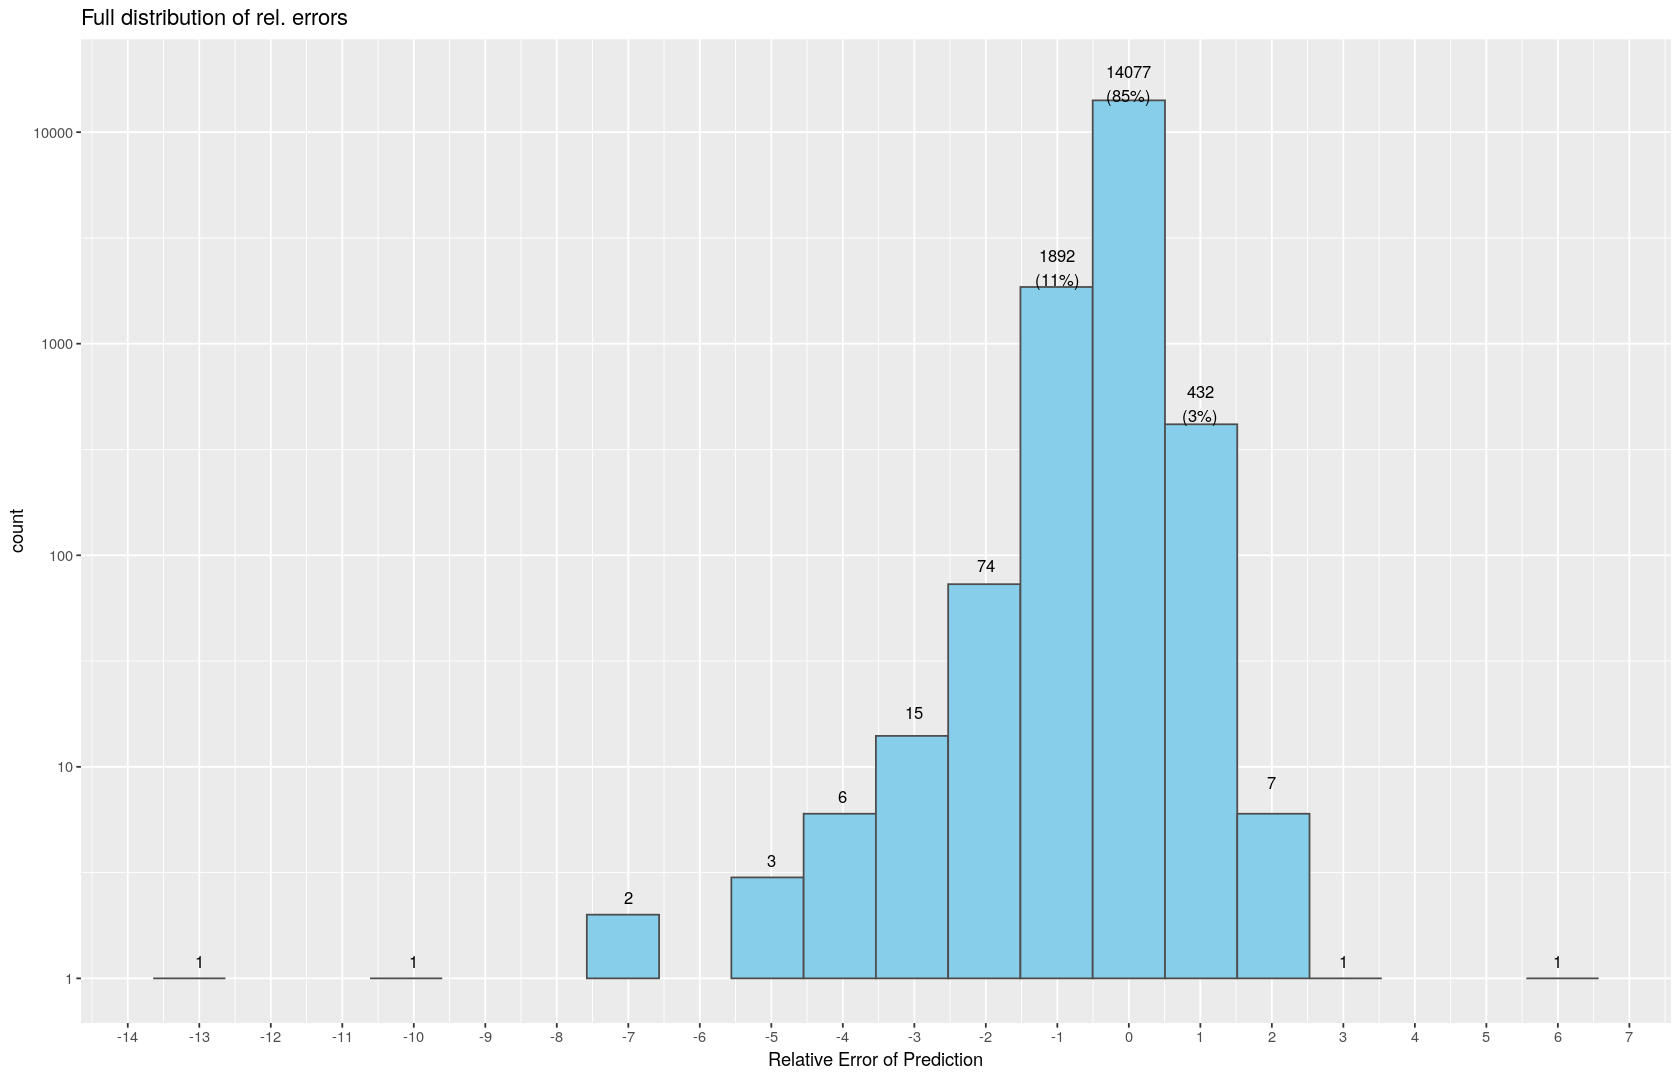

In [12]:
# train and evaluate accuracy on the training set
train_preds <- linmodel %>% predict(train) 
test_preds <- linmodel %>% predict(test)
train_info <- tibble(predictions=train_preds,
                     labels=train$median_house_value) %>%
    mutate(diff=abs(labels-predictions),
           sign=case_when(labels < predictions ~ -1, T ~ +1)) %>%
    mutate(diffrel=diff/labels)

ggplot(train_info, aes(x=diffrel*sign)) +
    geom_histogram(fill = 'skyblue', color = 'grey30', bins=20) + 
    stat_bin(geom="text", size=3.5, binwidth=1, 
             aes(label=case_when(..count.. < 100 ~ as.character(..count..),
                                 T ~ paste0(..count..,"\n(", round(..density..,2)*100, "%)")),
                 y=1.2*..count..)) +
    scale_x_continuous(breaks=seq(-100, 100)) +
    scale_y_log10() + 
    labs(title="Full distribution of rel. errors", x="Relative Error of Prediction")

Warning message:
“Removed 376 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 376 rows containing non-finite values (stat_bin).”


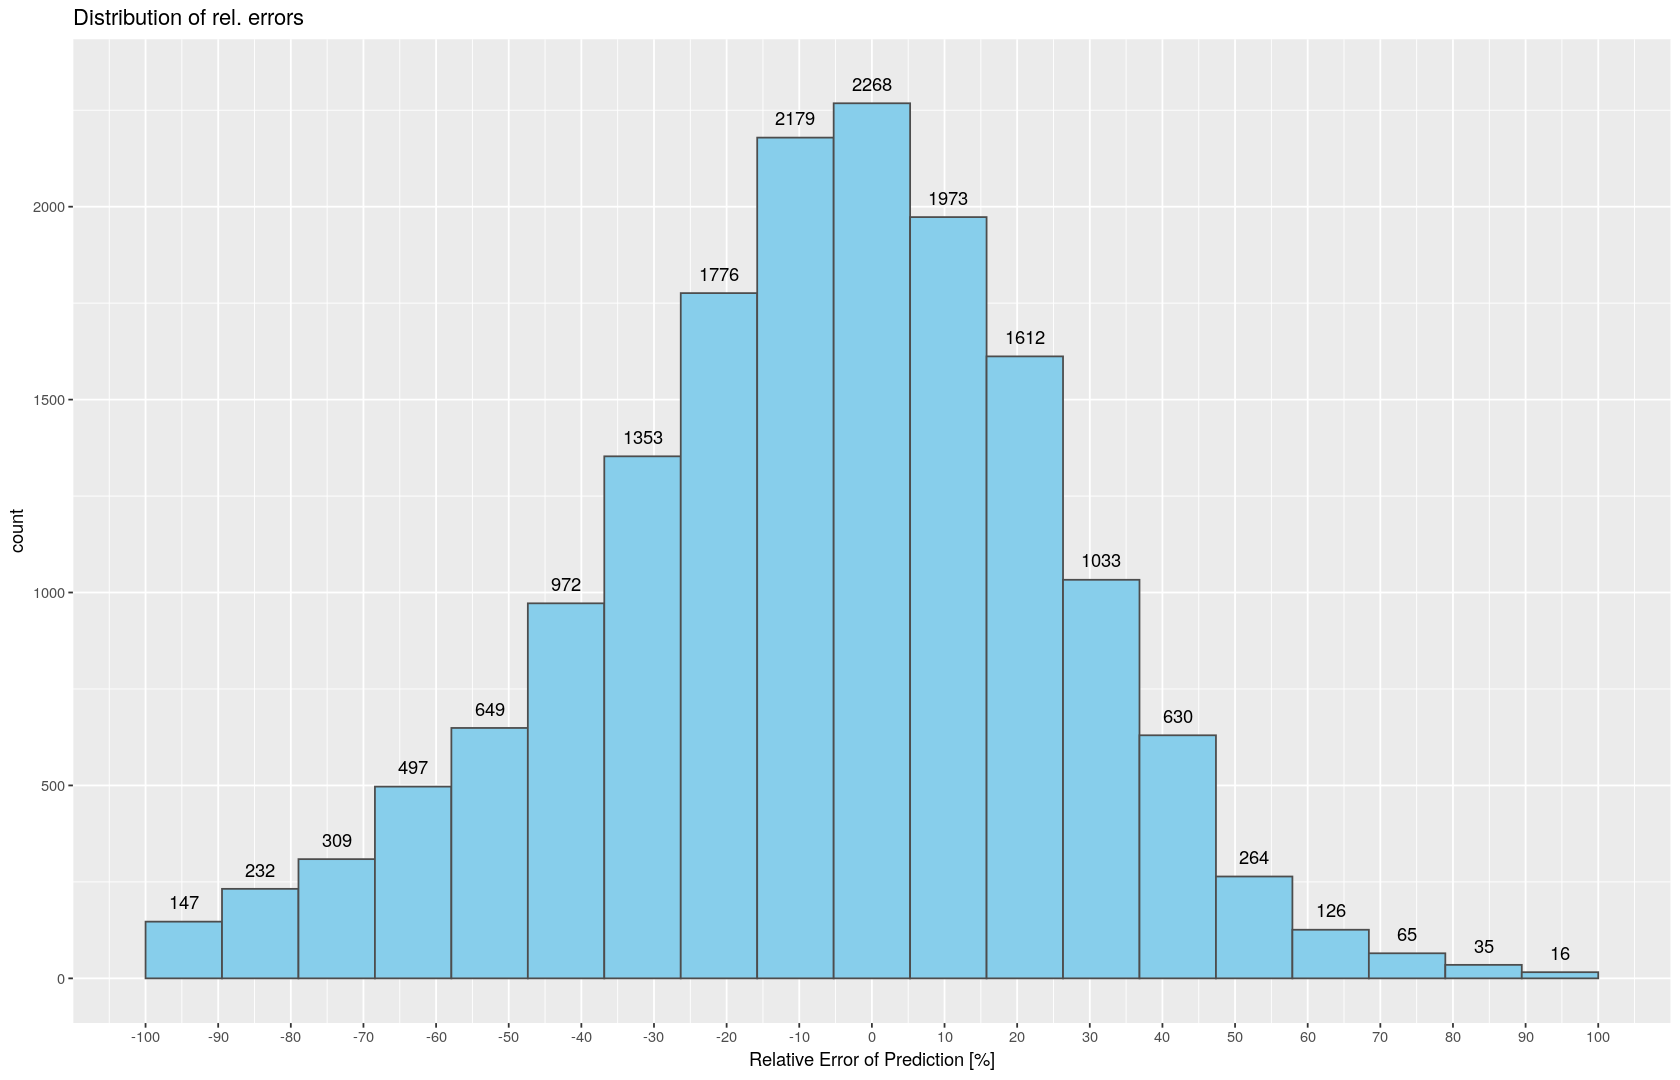

In [13]:
ggplot(train_info, aes(x=diffrel*sign)) +
    geom_histogram(fill = 'skyblue', color = 'grey30', bins=20) + 
    stat_bin(geom="text", aes(label=..count.., y=50+..count..), bins=20) +
    scale_x_continuous(labels = function(x)100*x, limits=c(-1, 1),
                      breaks=seq(-1,1,.1)) +
    labs(title="Distribution of rel. errors", x="Relative Error of Prediction [%]")

# Clean Slate

## Preparation

In [15]:
# load data from file
housing <- read.csv('_datasets/housing.csv') %>%
    as_tibble

# impute missing
housing <- housing %>%
    filter(!is.na(total_bedrooms))

# one-hot encode categorical variable
housing <- housing %>%
    mutate(dummy=1) %>%
    pivot_wider(names_from=ocean_proximity, values_from=dummy, values_fill=list(dummy=0))
    
# augment dataframe with further attributes
housing <- housing %>%
    mutate(rooms_per_household=total_rooms/households) %>%
    mutate(rooms_per_bedroom=total_rooms/total_bedrooms) %>%
    mutate(people_per_household=households/population)
    
# test/train split
test_indices <- sample(nrow(housing))[1:floor(0.2*nrow(housing))]
housing <- housing %>%
    mutate(split=case_when(row_number() %in% test_indices ~ "test", T ~ "train"))

# train the model
linfit <- lm(median_house_value ~ ., 
             data=housing %>% 
                  filter(split == "train") %>%
                  select(-c(split, ISLAND)))

# evaluate accuracy


mae,mae_sd
<dbl>,<dbl>
0.2795809,0.3369883


mae,mae_sd
<dbl>,<dbl>
0.2832974,0.369895


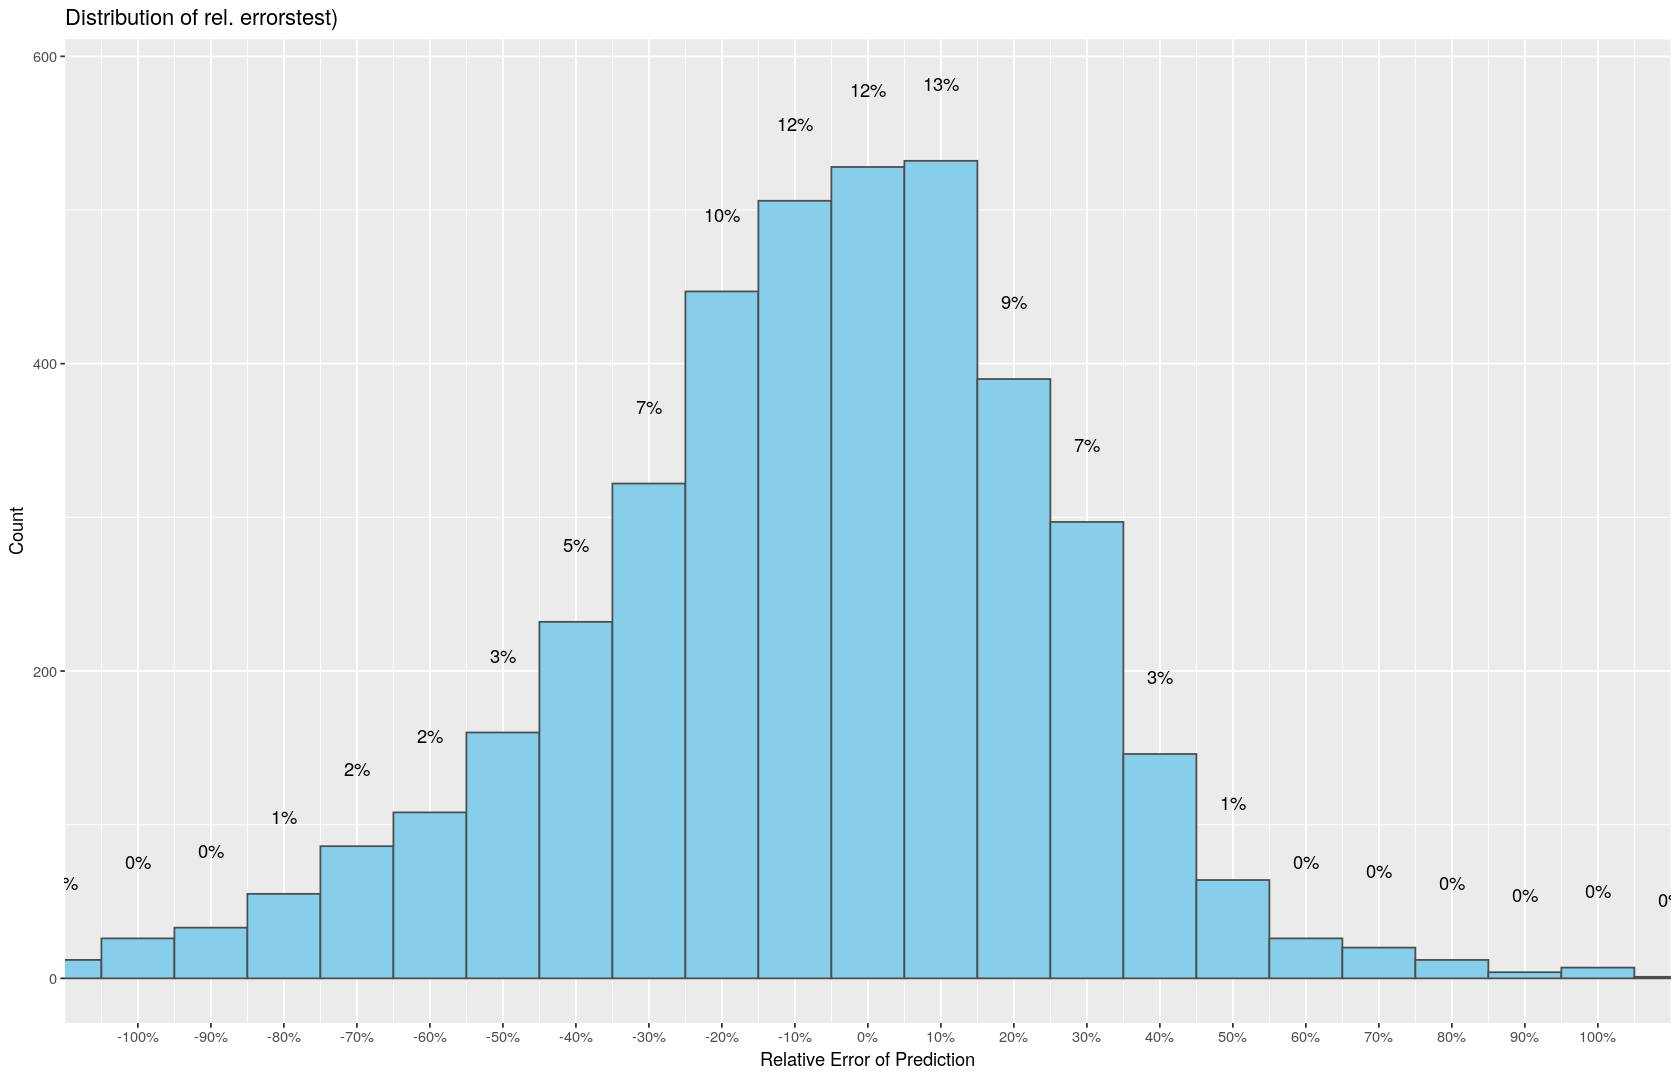

In [62]:
eval_acc <- function(model, fulldata, which_split, attribute="median_house_value") {
    # get predictions
    data <- fulldata %>% filter(split %in% which_split)
    info <- tibble(preds = model %>% predict(data),
                   labels = data[[attribute]],
                   offby = labels-preds,
                   offbyrel = offby/labels)
    
    boxplot <- ggplot(info) +
        geom_boxplot(aes(y=abs(offbyrel))) +
        scale_y_log10()
    
    histogram_full <- ggplot(info, aes(x=offbyrel)) +
        geom_histogram(binwidth=1, fill='skyblue', color='grey30') +
        stat_bin(aes(label = case_when(stat(count)/nrow(info) <= 0.01 ~ "≤1%", T ~ paste0(floor(..density..*100), "%")),
                     y = stat(count) * 1.2),
                 binwidth=1, geom="text") +
        scale_y_log10() +
        scale_x_continuous(labels = function(x) {paste0(100*x, "%")}, breaks=seq(-100,100),
                           limits=c(-15,15)) +
        labs(title=paste0("Full distribution of rel. errors (", toString(which_split), ")"), x="Relative Error of Prediction", y="Count")
    
    histogram_99 <- ggplot(info, aes(x=offbyrel)) +
        geom_histogram(binwidth=0.1, fill='skyblue', color='grey30') +
        coord_cartesian(xlim=c(-1,1)) +
        stat_bin(aes(label = paste0(floor(100*stat(count)/nrow(info)), "%"), y=..count..+50), geom="text", binwidth=0.1) +
        scale_x_continuous(labels = function(x) {paste0(100*x, "%")}, breaks=seq(-1,1,0.1)) +
        labs(title=paste0("Distribution of rel. errors", toString(which_split), ")"), x="Relative Error of Prediction", y="Count")
            
    stats <- info %>% summarize(mae=mean(abs(offbyrel)), mae_sd=sd(abs(offbyrel)))
    return(list(stats = stats, boxplot = boxplot, histogram_full = histogram_full, histogram_99 = histogram_99))
}
train_eval <- eval_acc(linfit, housing, "train")
test_eval <- eval_acc(linfit, housing, "test")
train_eval$stats
test_eval$stats
test_eval$histogram_99